# Didactic Notebook: Comparing Parameter Sharing Strategies in Multi-Task Learning

This notebook provides a hands-on comparison of different approaches to Multi-Task Learning (MTL) using a simplified Multi-Layer Perceptron (MLP) architecture on a derivative of the MNIST dataset. We will investigate:

1.  **Single-Task Learning (STL):** Training independent models for each task.
2.  **Hard Parameter Sharing:** Sharing initial layers across tasks.
3.  **Soft Parameter Sharing (Cross-Stitch Networks):** Learning to combine task-specific activations.

**Tasks:** Binary classification on MNIST digits: "Is Even?" and "Is Multiple of 3 (excluding 0)?".

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision.transforms import ToPILImage

# Import libraries for metrics, plotting, and timing
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time # Import the time module
import pandas as pd # Import pandas for the summary table

# --- Configuration ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- 1. Dataset Preparation for Multi-Task Learning ---

# Explanation:
# We create a custom dataset based on MNIST that provides the images
# and the labels for our two binary tasks: "is even?" and "is a multiple of 3 (and not 0)?".

print("\n--- 1. Dataset Preparation ---")

# Define transformations to apply to the MNIST images.
transform = transforms.Compose([
    transforms.ToTensor(), # Converts the PIL Image to a PyTorch Tensor (values between 0 and 1)
    transforms.Normalize((0.1307,), (0.3081,)) # Normalizes the tensor with MNIST mean and standard deviation
])

# Load the original MNIST datasets. We handle transforms manually in the custom dataset.
# download=True downloads the dataset if it's not already present
train_dataset_original = datasets.MNIST(root='./data', train=True, download=True, transform=None)
test_dataset_original = datasets.MNIST(root='./data', train=False, download=True, transform=None)

# Create a ToPILImage object for conversion - Needed because original.data is a Tensor
to_pil = ToPILImage()

# Define a Custom Dataset class for our multi-task problem.
class MNISTMultiTask(Dataset):
    def __init__(self, original_dataset, transform=None):
        self.original_dataset = original_dataset
        self.data = original_dataset.data
        self.targets = original_dataset.targets
        self.transform = transform

    def __len__(self):
        # The number of items in the dataset is equal to the original dataset
        return len(self.original_dataset)

    def __getitem__(self, idx):
        # Get the image (as an integer Tensor) and the original label
        img_tensor = self.data[idx]
        label_original = self.targets[idx].item() # .item() to get the scalar value

        # Convert the Tensor to a PIL Image to apply torchvision transforms
        # which often work better with PIL Images
        img_pil = to_pil(img_tensor)

        # Apply the specified transformations (ToTensor and Normalize)
        if self.transform:
            img_transformed = self.transform(img_pil)
        else:
             img_transformed = transforms.ToTensor()(img_pil)

        # Generate Task-Specific Labels
        # Task 1: Is it even? 1 if even, 0 if odd
        is_even_label = 1 if label_original % 2 == 0 else 0
        # Task 2: Is it a multiple of 3 (and not 0)? 1 if multiple of 3 and != 0, 0 otherwise
        is_multiple_of_3_label = 1 if label_original % 3 == 0 and label_original != 0 else 0

        # Return the transformed image and the labels for the two tasks (as float32 for BCEWithLogitsLoss)
        return img_transformed, torch.tensor(is_even_label, dtype=torch.float32), torch.tensor(is_multiple_of_3_label, dtype=torch.float32)

# Instantiate our custom datasets
train_dataset = MNISTMultiTask(train_dataset_original, transform=transform)
test_dataset = MNISTMultiTask(test_dataset_original, transform=transform)

# Create DataLoaders
batch_size = 128 # Batch size for training
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # Shuffle=True to shuffle training data
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) # Shuffle=False for consistent test results

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")
print(f"Shape of a training batch (Images, Even Labels, Mul3 Labels): {next(iter(train_loader))[0].shape, next(iter(train_loader))[1].shape, next(iter(train_loader))[2].shape}")


# --- Helper Function to count model parameters ---
def count_parameters(model):
    """Counts the number of trainable parameters in a PyTorch model."""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

Using device: cuda

--- 1. Dataset Preparation ---
Number of training samples: 60000
Number of test samples: 10000
Shape of a training batch (Images, Even Labels, Mul3 Labels): (torch.Size([128, 1, 28, 28]), torch.Size([128]), torch.Size([128]))


## 2. Model Architectures and Parameter Sharing Strategies

We will define three types of models for comparison:

1.  **Single-Task Models:** Two independent MLPs, one for each binary classification task.
2.  **Hard Parameter Sharing MTL Model:** A single MLP with shared hidden layers and task-specific output heads.
3.  **Cross-Stitch Network MTL Model:** Two parallel MLPs with Cross-Stitch units connecting corresponding layers for learned soft sharing.

For simplicity, all MLP backbones (shared or task-specific) will consist of only **two hidden layers**.

### Single-Task Models

In the Single-Task Learning (STL) approach, each task is learned by a completely separate neural network. This is the baseline to compare against MTL approaches.

In [ ]:
# --- 2. Definition of Models ---

# Shared parameters for model architecture consistency
input_size = 28 * 28 # MNIST images are 28x28 pixels
# Hidden layers: two layers
hidden_layers_sizes = [64, 32] # Sizes of the MLP hidden layers
output_size_binary = 1 # The output size for each binary classification task is a single logit


# --- Single-Task Model for "Is Even?" ---
class EvenMLP_SingleTask(nn.Module):
    def __init__(self, input_size, hidden_layers_sizes, output_size):
        super(EvenMLP_SingleTask, self).__init__()

        layers = []
        current_input_size = input_size
        # Builds the hidden layers (Linear + ReLU)
        for hidden_size in hidden_layers_sizes:
            layers.append(nn.Linear(current_input_size, hidden_size))
            layers.append(nn.ReLU())
            current_input_size = hidden_size
        # Adds the task-specific output layer for the "is even?" task
        layers.append(nn.Linear(current_input_size, output_size))

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        # Flattens the 28x28 image into a 784-element vector
        x = x.view(x.size(0), -1)
        # Passes the vector through the network
        return self.network(x)

# --- Single-Task Model for "Is Multiple of 3?" ---
class MultipleOf3MLP_SingleTask(nn.Module):
    def __init__(self, input_size, hidden_layers_sizes, output_size):
        super(MultipleOf3MLP_SingleTask, self).__init__()

        layers = []
        current_input_size = input_size
        # Builds the hidden layers (Linear + ReLU)
        for hidden_size in hidden_layers_sizes:
            layers.append(nn.Linear(current_input_size, hidden_size))
            layers.append(nn.ReLU())
            current_input_size = hidden_size
        # Adds the task-specific output layer for the "is multiple of 3?" task
        layers.append(nn.Linear(current_input_size, output_size))

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.network(x)

### Hard Parameter Sharing

Hard Parameter Sharing is a common MTL approach where a significant portion of the network (the backbone) is shared between tasks, while only the final layers (heads) are task-specific. This reduces the total parameter count and can act as a strong regularizer.

In [8]:
# --- Multi-Task Learning (MTL) Model - Hard Parameter Sharing ---
class MultiTaskMLP_HardSharing(nn.Module):
    def __init__(self, input_size, hidden_layers_sizes, output_sizes):
        super(MultiTaskMLP_HardSharing, self).__init__()

        # Shared Backbone
        layers = []
        current_input_size = input_size
        for hidden_size in hidden_layers_sizes:
            layers.append(nn.Linear(current_input_size, hidden_size))
            layers.append(nn.ReLU())
            current_input_size = hidden_size
        self.backbone = nn.Sequential(*layers)

        # Task-Specific Heads - operate on the output of the shared backbone
        self.even_head = nn.Linear(current_input_size, output_sizes['even'])
        self.multiple_of_3_head = nn.Linear(current_input_size, output_sizes['multiple_of_3'])

    def forward(self, x):
        x = x.view(x.size(0), -1)
        shared_representation = self.backbone(x)
        even_output = self.even_head(shared_representation)
        multiple_of_3_output = self.multiple_of_3_head(shared_representation)
        return even_output, multiple_of_3_output

### Soft Parameter Sharing: Cross-Stitch Networks

Cross-Stitch Networks offer a Soft Parameter Sharing approach. Instead of rigidly sharing layers, they learn to combine the feature maps (activations) from task-specific network branches using learned scalar weights ($\alpha$) at different levels. This allows for a more flexible information flow between tasks.

The core component is the `CrossStitchUnit`. For activations $x_A^l, x_B^l$ from task A and B at layer $l$, the combined activations $\tilde{x}_A^l, \tilde{x}_B^l$ are:

$$
\begin{pmatrix} \tilde{x}_A^l \\ \tilde{x}_B^l \end{pmatrix} = \begin{pmatrix} \alpha_{AA} & \alpha_{AB} \\ \alpha_{BA} & \alpha_{BB} \end{pmatrix} \begin{pmatrix} x_A^l \\ x_B^l \end{pmatrix}
$$

where $\alpha_{AA}, \alpha_{AB}, \alpha_{BA}, \alpha_{BB}$ are learned scalars. This operation is applied element-wise across the activation tensors.

The `MultiTaskMLP_CrossStitch` model consists of parallel branches for each task, with `CrossStitchUnit` instances placed between corresponding layers.

In [9]:
# --- Cross-Stitch Unit for Soft Parameter Sharing ---
class CrossStitchUnit(nn.Module):
    """
    A Cross-Stitch Unit combines activation tensors from two task-specific branches
    via a learned linear combination defined by scalar parameters.
    """
    def __init__(self, num_channels):
        super(CrossStitchUnit, self).__init__()
        # Alpha parameters (2x2 matrix) are learned scalars.
        # Initialized to identity matrix to start with independent processing.
        self.alpha = nn.Parameter(torch.eye(2, 2))

    def forward(self, input1, input2):
        """
        Performs the cross-stitch operation: learned scalar-weighted element-wise sum.
        """
        input1 = input1.to(self.alpha.device)
        input2 = input2.to(self.alpha.device)

        # Output1 = alpha[0, 0] * Input1 + alpha[0, 1] * Input2
        # Output2 = alpha[1, 0] * Input1 + alpha[1, 1] * Input2
        output1 = self.alpha[0, 0] * input1 + self.alpha[0, 1] * input2
        output2 = self.alpha[1, 0] * input1 + self.alpha[1, 1] * input2

        return output1, output2

# --- Multi-Task Learning (MTL) Model - Cross-Stitch Sharing ---
class MultiTaskMLP_CrossStitch(nn.Module):
    def __init__(self, input_size, hidden_layers_sizes, output_sizes):
        super(MultiTaskMLP_CrossStitch, self).__init__()

        self.input_size = input_size
        self.hidden_layers_sizes = hidden_layers_sizes
        self.output_sizes = output_sizes

        # Create parallel branches for each task
        self.even_branch = nn.ModuleList() # Layers for the "even" branch
        self.mul3_branch = nn.ModuleList() # Layers for the "multiple of 3" branch
        self.cross_stitch_units = nn.ModuleList() # Cross-Stitch Units

        current_input_size = input_size
        # Build layers for the branches and add Cross-Stitch Units
        for i, hidden_size in enumerate(hidden_layers_sizes):
            # Add Linear layer and ReLU for each branch
            self.even_branch.append(nn.Linear(current_input_size, hidden_size))
            self.even_branch.append(nn.ReLU())

            self.mul3_branch.append(nn.Linear(current_input_size, hidden_size))
            self.mul3_branch.append(nn.ReLU())

            # Add a Cross-Stitch unit *after* the activation function
            self.cross_stitch_units.append(CrossStitchUnit(hidden_size))

            current_input_size = hidden_size # Update input size for the next layer

        # Task-Specific Output Heads (operate on the output of the last cross-stitched layer)
        self.even_head = nn.Linear(hidden_layers_sizes[-1], output_sizes['even'])
        self.multiple_of_3_head = nn.Linear(hidden_layers_sizes[-1], output_sizes['multiple_of_3'])


    def forward(self, x):
        x = x.view(x.size(0), -1) # Flatten input

        # Initialize inputs for the first layer of each branch
        even_x = x
        mul3_x = x

        # Pass through the parallel branches and apply Cross-Stitch units
        # We process layers in pairs (Linear + ReLU), then apply Cross-Stitch
        for i in range(len(self.hidden_layers_sizes)):
            # Apply Linear and ReLU for each branch
            even_x = self.even_branch[i * 2](even_x)
            even_x = self.even_branch[i * 2 + 1](even_x)

            mul3_x = self.mul3_branch[i * 2](mul3_x)
            mul3_x = self.mul3_branch[i * 2 + 1](mul3_x)

            # Apply the Cross-Stitch unit to the activated outputs
            even_x, mul3_x = self.cross_stitch_units[i](even_x, mul3_x)

        # Pass the final representations through task-specific heads
        even_output = self.even_head(even_x)
        multiple_of_3_output = self.multiple_of_3_head(mul3_x)

        return even_output, multiple_of_3_output

# --- Instantiate Models ---
print("\nInstantiating Models...")
even_single_model = EvenMLP_SingleTask(input_size, hidden_layers_sizes, output_size_binary).to(device)
mul3_single_model = MultipleOf3MLP_SingleTask(input_size, hidden_layers_sizes, output_size_binary).to(device)
mtl_hard_model = MultiTaskMLP_HardSharing(input_size, hidden_layers_sizes, {'even': output_size_binary, 'multiple_of_3': output_size_binary}).to(device)
mtl_cross_stitch_model = MultiTaskMLP_CrossStitch(input_size, hidden_layers_sizes, {'even': output_size_binary, 'multiple_of_3': output_size_binary}).to(device)


# Print parameter counts
print(f"Even-only Single-Task Model Parameters: {count_parameters(even_single_model)}")
print(f"MultipleOf3-only Single-Task Model Parameters: {count_parameters(mul3_single_model)}")
print(f"Sum of Single-Task Model Parameters: {count_parameters(even_single_model) + count_parameters(mul3_single_model)}")
print(f"MTL Hard Sharing Model Parameters: {count_parameters(mtl_hard_model)}")
print(f"MTL Cross-Stitch Model Parameters: {count_parameters(mtl_cross_stitch_model)}")
# Cross-Stitch vs Sum of Single-Task: CS adds 4 trainable alpha parameters per Cross-Stitch Unit (here 2 units).
# Sum of Single-Task is 2 * (input*h1 + h1*h2 + h2*output + biases)
# Hard Sharing is (input*h1 + h1*h2 + biases_backbone) + 2*(h2*output + biases_head)
# Cross-Stitch is 2 * (input*h1 + h1*h2 + biases_branches) + 2*(h2*output + biases_heads) + num_units * 4
print(f"Parameter Difference (Cross-Stitch vs Sum of Single-Task): {count_parameters(mtl_cross_stitch_model) - (count_parameters(even_single_model) + count_parameters(mul3_single_model))}")
print(f"Parameter Reduction (Hard Sharing vs Sum of Single-Task): {(count_parameters(even_single_model) + count_parameters(mul3_single_model)) - count_parameters(mtl_hard_model)}")


Instantiating Models...
Even-only Single-Task Model Parameters: 52353
MultipleOf3-only Single-Task Model Parameters: 52353
Sum of Single-Task Model Parameters: 104706
MTL Hard Sharing Model Parameters: 52386
MTL Cross-Stitch Model Parameters: 104714
Parameter Difference (Cross-Stitch vs Sum of Single-Task): 8
Parameter Reduction (Hard Sharing vs Sum of Single-Task): 52320


## 3. Loss Functions, Optimizers, and Training Setup

We define the loss functions (Binary Cross Entropy with Logits) for our binary tasks and Adam optimizers for each model.

For MTL models, the total loss is the sum of the individual task losses. We will track the training loss and test accuracy over epochs to monitor progress and save the best performing model state for final evaluation.

In [10]:
# --- 3. Define Loss Functions and Optimizers ---
# BCEWithLogitsLoss is used for binary classification (combines Sigmoid and BCELoss)
criterion_even = nn.BCEWithLogitsLoss()
criterion_multiple_of_3 = nn.BCEWithLogitsLoss()

# Optimizers for each model
optimizer_even_single = optim.Adam(even_single_model.parameters(), lr=0.001)
optimizer_mul3_single = optim.Adam(mul3_single_model.parameters(), lr=0.001)
optimizer_mtl_hard = optim.Adam(mtl_hard_model.parameters(), lr=0.001)
optimizer_mtl_cross_stitch = optim.Adam(mtl_cross_stitch_model.parameters(), lr=0.001)

# --- Training Configuration ---
num_epochs = 25 # Number of epochs for training

# --- Early Stopping Configuration (used only for tracking best model state) ---
# Minimum change in the monitored metric to qualify as an improvement for saving the model state
min_delta = 0.001

# --- Lists to store metrics for plotting ---
even_single_train_losses = []
mul3_single_train_losses = []
mtl_hard_train_losses = []
mtl_cross_stitch_train_losses = []

even_single_test_accuracies = []
mul3_single_test_accuracies = []
mtl_hard_even_test_accuracies = []
mtl_hard_mul3_test_accuracies = []
mtl_cross_stitch_even_test_accuracies = []
mtl_cross_stitch_mul3_test_accuracies = []


# --- Helper Function to Evaluate a Model and Calculate Accuracy ---
# This function is called periodically during training to evaluate performance
# on the test set and help save the best model state.
def get_test_accuracy(model, loader, device, task_type):
    """
    Evaluates the model's accuracy on the test set.

    Args:
        model (nn.Module): The model to evaluate.
        loader (DataLoader): The DataLoader for the test set.
        device (torch.device): The device to run evaluation on (cpu or cuda).
        task_type (str): Specifies the model type for correct output handling.
                         ('even_single', 'mul3_single', 'mtl_hard', 'mtl_cross_stitch')

    Returns:
        float: Accuracy for single-task models.
        tuple: (accuracy_even, accuracy_mul3, average_accuracy) for MTL models.
    """
    model.eval() # Set the model to evaluation mode
    with torch.no_grad(): # Disable gradient calculation
        if task_type in ['even_single', 'mul3_single']:
            correct = 0
            total = 0
            # Determine which labels to use based on task_type
            label_index = 1 if task_type == 'even_single' else 2 # 1 for even, 2 for mul3 in batch tuple
            for images, label1, label2 in loader:
                labels = label1 if task_type == 'even_single' else label2
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                predictions = torch.round(F.sigmoid(outputs.squeeze()))
                total += labels.size(0)
                correct += (predictions == labels).sum().item()
            accuracy = 100 * correct / total
            return accuracy

        elif task_type in ['mtl_hard', 'mtl_cross_stitch']:
            all_even_labels = []
            all_even_preds = []
            all_mul3_labels = []
            all_mul3_preds = []

            for images, even_labels, multiple_of_3_labels in loader:
                images, even_labels, multiple_of_3_labels = images.to(device), even_labels.to(device), multiple_of_3_labels.to(device)
                outputs_even, outputs_mul3 = model(images)

                preds_even = torch.round(F.sigmoid(outputs_even.squeeze()))
                preds_mul3 = torch.round(F.sigmoid(outputs_mul3.squeeze()))

                all_even_labels.extend(even_labels.cpu().numpy())
                all_even_preds.extend(preds_even.cpu().numpy())
                all_mul3_labels.extend(multiple_of_3_labels.cpu().numpy())
                all_mul3_preds.extend(preds_mul3.cpu().numpy())

            all_even_labels_np = np.array(all_even_labels)
            all_even_preds_np = np.array(all_even_preds)
            all_mul3_labels_np = np.array(all_mul3_labels)
            all_mul3_preds_np = np.array(all_mul3_preds)

            acc_even = (all_even_labels_np == all_even_preds_np).mean() * 100
            acc_mul3 = (all_mul3_labels_np == all_mul3_preds_np).mean() * 100
            avg_acc = (acc_even + acc_mul3) / 2

            return acc_even, acc_mul3, avg_acc
        else:
             raise ValueError(f"Unknown task_type: {task_type}")

## 4. Training the Models

We train the three different model types sequentially: first the two Single-Task models independently, then the Hard Parameter Sharing model, and finally the Cross-Stitch Network model.

For each model, we save the state that achieves the best performance on the test set throughout the training process.

In [11]:
# --- Training Loops ---

# --- Train Even-only Single-Task Model ---
print("\nStarting Even-only Single-Task Model Training...")
start_time_even_single_train = time.time()

best_even_single_test_acc = -float('inf')
best_even_single_state_dict = None

for epoch in range(num_epochs):
    even_single_model.train()
    running_loss = 0.0
    for images, even_labels, _ in train_loader:
        images, even_labels = images.to(device), even_labels.to(device)
        optimizer_even_single.zero_grad()
        even_outputs = even_single_model(images)
        loss_even = criterion_even(even_outputs.squeeze(), even_labels)
        loss_even.backward()
        optimizer_even_single.step()
        running_loss += loss_even.item()

    epoch_loss = running_loss / len(train_loader)
    even_single_train_losses.append(epoch_loss)
    print(f"Even-only Single-Task Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    current_even_single_test_acc = get_test_accuracy(even_single_model, test_loader, device, task_type='even_single')
    even_single_test_accuracies.append(current_even_single_test_acc)
    print(f"Even-only Single-Task Epoch [{epoch+1}/{num_epochs}] - Test Accuracy: {current_even_single_test_acc:.2f}%")

    if current_even_single_test_acc > best_even_single_test_acc + min_delta:
        best_even_single_test_acc = current_even_single_test_acc
        best_even_single_state_dict = even_single_model.state_dict()
        print(f"Even-only Single-Task Test Accuracy improved to {best_even_single_test_acc:.2f}%. Saving model state.")
    else:
        print(f"Even-only Single-Task Test Accuracy did not improve from {best_even_single_test_acc:.2f}%.")

if best_even_single_state_dict is not None:
    even_single_model.load_state_dict(best_even_single_state_dict)
    print("Loaded best Even-only Single-Task model state.")
else:
     print("No Even-only Single-Task model state saved. Using final epoch state.")

end_time_even_single_train = time.time()
even_single_train_time = end_time_even_single_train - start_time_even_single_train
print(f"Even-only Single-Task Model Training Time: {even_single_train_time:.4f} seconds (Completed {num_epochs} epochs, using best state)")


# --- Train MultipleOf3-only Single-Task Model ---
print("\nStarting MultipleOf3-only Single-Task Model Training...")
start_time_mul3_single_train = time.time()

best_mul3_single_test_acc = -float('inf')
best_mul3_single_state_dict = None

for epoch in range(num_epochs):
    mul3_single_model.train()
    running_loss = 0.0
    for images, _, multiple_of_3_labels in train_loader:
        images, multiple_of_3_labels = images.to(device), multiple_of_3_labels.to(device)
        optimizer_mul3_single.zero_grad()
        mul3_outputs = mul3_single_model(images)
        loss_mul3 = criterion_multiple_of_3(mul3_outputs.squeeze(), multiple_of_3_labels)
        loss_mul3.backward()
        optimizer_mul3_single.step()
        running_loss += loss_mul3.item()

    epoch_loss = running_loss / len(train_loader)
    mul3_single_train_losses.append(epoch_loss)
    print(f"MultipleOf3-only Single-Task Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    current_mul3_single_test_acc = get_test_accuracy(mul3_single_model, test_loader, device, task_type='mul3_single')
    mul3_single_test_accuracies.append(current_mul3_single_test_acc)
    print(f"MultipleOf3-only Single-Task Epoch [{epoch+1}/{num_epochs}] - Test Accuracy: {current_mul3_single_test_acc:.2f}%")

    if current_mul3_single_test_acc > best_mul3_single_test_acc + min_delta:
        best_mul3_single_test_acc = current_mul3_single_test_acc
        best_mul3_single_state_dict = mul3_single_model.state_dict()
        print(f"MultipleOf3-only Single-Task Test Accuracy improved to {best_mul3_single_test_acc:.2f}%. Saving model state.")
    else:
        print(f"MultipleOf3-only Single-Task Test Accuracy did not improve from {best_mul3_single_test_acc:.2f}%.")

if best_mul3_single_state_dict is not None:
    mul3_single_model.load_state_dict(best_mul3_single_state_dict)
    print("Loaded best MultipleOf3-only Single-Task model state.")
else:
     print("No MultipleOf3-only Single-Task model state saved. Using final epoch state.")

end_time_mul3_single_train = time.time()
mul3_single_train_time = end_time_mul3_single_train - start_time_mul3_single_train
print(f"MultipleOf3-only Single-Task Model Training Time: {mul3_single_train_time:.4f} seconds (Completed {num_epochs} epochs, using best state)")


# --- Train MTL Hard Sharing Model ---
print("\nStarting MTL Hard Sharing Model Training...")
start_time_mtl_hard_train = time.time()

best_mtl_hard_avg_test_acc = -float('inf')
best_mtl_hard_state_dict = None

for epoch in range(num_epochs):
    mtl_hard_model.train()
    running_loss = 0.0
    for images, even_labels, multiple_of_3_labels in train_loader:
        images, even_labels, multiple_of_3_labels = images.to(device), even_labels.to(device), multiple_of_3_labels.to(device)
        optimizer_mtl_hard.zero_grad()
        even_outputs, multiple_of_3_outputs = mtl_hard_model(images)
        loss_even = criterion_even(even_outputs.squeeze(), even_labels)
        loss_multiple_of_3 = criterion_multiple_of_3(multiple_of_3_outputs.squeeze(), multiple_of_3_labels)
        total_loss = loss_even + loss_multiple_of_3
        total_loss.backward()
        optimizer_mtl_hard.step()
        running_loss += total_loss.item()

    epoch_loss = running_loss / len(train_loader)
    mtl_hard_train_losses.append(epoch_loss)
    print(f"MTL Hard Sharing Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    mtl_hard_even_acc, mtl_hard_mul3_acc, current_mtl_hard_avg_test_acc = get_test_accuracy(mtl_hard_model, test_loader, device, task_type='mtl_hard')
    mtl_hard_even_test_accuracies.append(mtl_hard_even_acc)
    mtl_hard_mul3_test_accuracies.append(mtl_hard_mul3_acc)

    print(f"MTL Hard Sharing Epoch [{epoch+1}/{num_epochs}] - Test Accuracy (Even): {mtl_hard_even_acc:.2f}%, Test Accuracy (Mul3): {mtl_hard_mul3_acc:.2f}%, Avg Test Accuracy: {current_mtl_hard_avg_test_acc:.2f}%")

    if current_mtl_hard_avg_test_acc > best_mtl_hard_avg_test_acc + min_delta:
        best_mtl_hard_avg_test_acc = current_mtl_hard_avg_test_acc
        best_mtl_hard_state_dict = mtl_hard_model.state_dict()
        print(f"MTL Hard Sharing Avg Test Accuracy improved to {best_mtl_hard_avg_test_acc:.2f}%. Saving model state.")
    else:
        print(f"MTL Hard Sharing Avg Test Accuracy did not improve from {best_mtl_hard_avg_test_acc:.2f}%.")

if best_mtl_hard_state_dict is not None:
    mtl_hard_model.load_state_dict(best_mtl_hard_state_dict)
    print("Loaded best MTL Hard Sharing model state.")
else:
     print("No MTL Hard Sharing model state saved. Using final epoch state.")

end_time_mtl_hard_train = time.time()
mtl_hard_train_time = end_time_mtl_hard_train - start_time_mtl_hard_train
print(f"MTL Hard Sharing Model Training Time: {mtl_hard_train_time:.4f} seconds (Completed {num_epochs} epochs, using best state)")


# --- Train MTL Cross-Stitch Model ---
print("\nStarting MTL Cross-Stitch Model Training...")
start_time_mtl_cross_stitch_train = time.time()

best_mtl_cross_stitch_avg_test_acc = -float('inf')
best_mtl_cross_stitch_state_dict = None

for epoch in range(num_epochs):
    mtl_cross_stitch_model.train()
    running_loss = 0.0
    for images, even_labels, multiple_of_3_labels in train_loader:
        images, even_labels, multiple_of_3_labels = images.to(device), even_labels.to(device), multiple_of_3_labels.to(device)
        optimizer_mtl_cross_stitch.zero_grad()
        even_outputs, multiple_of_3_outputs = mtl_cross_stitch_model(images)
        loss_even = criterion_even(even_outputs.squeeze(), even_labels)
        loss_multiple_of_3 = criterion_multiple_of_3(multiple_of_3_outputs.squeeze(), multiple_of_3_labels)
        total_loss = loss_even + loss_multiple_of_3
        total_loss.backward()
        optimizer_mtl_cross_stitch.step()
        running_loss += total_loss.item()

    epoch_loss = running_loss / len(train_loader)
    mtl_cross_stitch_train_losses.append(epoch_loss)
    print(f"MTL Cross-Stitch Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    mtl_cross_stitch_even_acc, mtl_cross_stitch_mul3_acc, current_mtl_cross_stitch_avg_test_acc = get_test_accuracy(mtl_cross_stitch_model, test_loader, device, task_type='mtl_cross_stitch')
    mtl_cross_stitch_even_test_accuracies.append(mtl_cross_stitch_even_acc)
    mtl_cross_stitch_mul3_test_accuracies.append(mtl_cross_stitch_mul3_acc)

    print(f"MTL Cross-Stitch Epoch [{epoch+1}/{num_epochs}] - Test Accuracy (Even): {mtl_cross_stitch_even_acc:.2f}%, Test Accuracy (Mul3): {mtl_cross_stitch_mul3_acc:.2f}%, Avg Test Accuracy: {current_mtl_cross_stitch_avg_test_acc:.2f}%")

    if current_mtl_cross_stitch_avg_test_acc > best_mtl_cross_stitch_avg_test_acc + min_delta:
        best_mtl_cross_stitch_avg_test_acc = current_mtl_cross_stitch_avg_test_acc
        best_mtl_cross_stitch_state_dict = mtl_cross_stitch_model.state_dict()
        print(f"MTL Cross-Stitch Avg Test Accuracy improved to {best_mtl_cross_stitch_avg_test_acc:.2f}%. Saving model state.")
    else:
        print(f"MTL Cross-Stitch Avg Test Accuracy did not improve from {best_mtl_cross_stitch_avg_test_acc:.2f}%.")

if best_mtl_cross_stitch_state_dict is not None:
    mtl_cross_stitch_model.load_state_dict(best_mtl_cross_stitch_state_dict)
    print("Loaded best MTL Cross-Stitch model state.")
else:
     print("No MTL Cross-Stitch model state saved. Using final epoch state.")

end_time_mtl_cross_stitch_train = time.time()
mtl_cross_stitch_train_time = end_time_mtl_cross_stitch_train - start_time_mtl_cross_stitch_train
print(f"MTL Cross-Stitch Model Training Time: {mtl_cross_stitch_train_time:.4f} seconds (Completed {num_epochs} epochs, using best state)")


Starting Even-only Single-Task Model Training...
Even-only Single-Task Epoch [1/25], Loss: 0.1501
Even-only Single-Task Epoch [1/25] - Test Accuracy: 97.38%
Even-only Single-Task Test Accuracy improved to 97.38%. Saving model state.
Even-only Single-Task Epoch [2/25], Loss: 0.0658
Even-only Single-Task Epoch [2/25] - Test Accuracy: 98.04%
Even-only Single-Task Test Accuracy improved to 98.04%. Saving model state.
Even-only Single-Task Epoch [3/25], Loss: 0.0497
Even-only Single-Task Epoch [3/25] - Test Accuracy: 98.48%
Even-only Single-Task Test Accuracy improved to 98.48%. Saving model state.
Even-only Single-Task Epoch [4/25], Loss: 0.0401
Even-only Single-Task Epoch [4/25] - Test Accuracy: 98.15%
Even-only Single-Task Test Accuracy did not improve from 98.48%.
Even-only Single-Task Epoch [5/25], Loss: 0.0338
Even-only Single-Task Epoch [5/25] - Test Accuracy: 98.52%
Even-only Single-Task Test Accuracy improved to 98.52%. Saving model state.
Even-only Single-Task Epoch [6/25], Loss:

## 5. Final Evaluation and Comparison of Results

After training, we perform a final evaluation using the best model states saved for each approach. We will calculate and compare key metrics, parameter counts, and training/inference times.

In [12]:
# --- 5. Final Evaluation for Comparison Metrics ---

print("\n--- 5. Final Evaluation and Comparison ---")

# --- Evaluate Even-only Single-Task Model ---
print("\nFinal Evaluation: Even-only Single-Task Model...")
even_single_model.eval()
all_even_labels_even_single = []
all_even_preds_even_single = []
start_time_even_single_inference = time.time()
with torch.no_grad():
    for images, even_labels, _ in test_loader:
        images = images.to(device)
        even_outputs = even_single_model(images)
        even_predictions = torch.round(F.sigmoid(even_outputs.squeeze()))
        all_even_labels_even_single.extend(even_labels.cpu().numpy())
        all_even_preds_even_single.extend(even_predictions.cpu().numpy())
end_time_even_single_inference = time.time()
even_single_inference_time = time.time() - start_time_even_single_inference
all_even_labels_even_single = np.array(all_even_labels_even_single)
all_even_preds_even_single = np.array(all_even_preds_even_single)

# --- Evaluate MultipleOf3-only Single-Task Model ---
print("\nFinal Evaluation: MultipleOf3-only Single-Task Model...")
mul3_single_model.eval()
all_multiple_of_3_labels_mul3_single = []
all_multiple_of_3_preds_mul3_single = []
start_time_mul3_single_inference = time.time()
with torch.no_grad():
    for images, _, multiple_of_3_labels in test_loader:
        images = images.to(device)
        mul3_outputs = mul3_single_model(images)
        multiple_of_3_predictions = torch.round(F.sigmoid(mul3_outputs.squeeze()))
        all_multiple_of_3_labels_mul3_single.extend(multiple_of_3_labels.cpu().numpy())
        all_multiple_of_3_preds_mul3_single.extend(multiple_of_3_predictions.cpu().numpy())
end_time_mul3_single_inference = time.time()
mul3_single_inference_time = time.time() - start_time_mul3_single_inference
all_multiple_of_3_labels_mul3_single = np.array(all_multiple_of_3_labels_mul3_single)
all_multiple_of_3_preds_mul3_single = np.array(all_multiple_of_3_preds_mul3_single)


# --- Evaluate MTL Hard Sharing Model ---
print("\nFinal Evaluation: MTL Hard Sharing Model...")
mtl_hard_model.eval()
all_even_labels_mtl_hard = []
all_even_preds_mtl_hard = []
all_multiple_of_3_labels_mtl_hard = []
all_multiple_of_3_preds_mtl_hard = []
start_time_mtl_hard_inference = time.time()
with torch.no_grad():
    for images, even_labels, multiple_of_3_labels in test_loader:
        images = images.to(device)
        even_outputs, multiple_of_3_outputs = mtl_hard_model(images)
        even_predictions = torch.round(F.sigmoid(even_outputs.squeeze()))
        multiple_of_3_predictions = torch.round(F.sigmoid(multiple_of_3_outputs.squeeze()))
        all_even_labels_mtl_hard.extend(even_labels.cpu().numpy())
        all_even_preds_mtl_hard.extend(even_predictions.cpu().numpy())
        all_multiple_of_3_labels_mtl_hard.extend(multiple_of_3_labels.cpu().numpy())
        all_multiple_of_3_preds_mtl_hard.extend(multiple_of_3_predictions.cpu().numpy())
end_time_mtl_hard_inference = time.time()
mtl_hard_inference_time = end_time_mtl_hard_inference - start_time_mtl_hard_inference
all_even_labels_mtl_hard = np.array(all_even_labels_mtl_hard)
all_even_preds_mtl_hard = np.array(all_even_preds_mtl_hard)
all_multiple_of_3_labels_mtl_hard = np.array(all_multiple_of_3_labels_mtl_hard)
all_multiple_of_3_preds_mtl_hard = np.array(all_multiple_of_3_preds_mtl_hard)


# --- Evaluate MTL Cross-Stitch Model ---
print("\nFinal Evaluation: MTL Cross-Stitch Model...")
mtl_cross_stitch_model.eval()
all_even_labels_mtl_cross_stitch = []
all_even_preds_mtl_cross_stitch = []
all_multiple_of_3_labels_mtl_cross_stitch = []
all_multiple_of_3_preds_mtl_cross_stitch = []
start_time_mtl_cross_stitch_inference = time.time()
with torch.no_grad():
    for images, even_labels, multiple_of_3_labels in test_loader:
        images = images.to(device)
        even_outputs, multiple_of_3_outputs = mtl_cross_stitch_model(images)
        even_predictions = torch.round(F.sigmoid(even_outputs.squeeze()))
        multiple_of_3_predictions = torch.round(F.sigmoid(multiple_of_3_outputs.squeeze()))
        all_even_labels_mtl_cross_stitch.extend(even_labels.cpu().numpy())
        all_even_preds_mtl_cross_stitch.extend(even_predictions.cpu().numpy())
        all_multiple_of_3_labels_mtl_cross_stitch.extend(multiple_of_3_labels.cpu().numpy())
        all_multiple_of_3_preds_mtl_cross_stitch.extend(multiple_of_3_predictions.cpu().numpy())
end_time_mtl_cross_stitch_inference = time.time()
mtl_cross_stitch_inference_time = end_time_mtl_cross_stitch_inference - start_time_mtl_cross_stitch_inference
all_even_labels_mtl_cross_stitch = np.array(all_even_labels_mtl_cross_stitch)
all_even_preds_mtl_cross_stitch = np.array(all_even_preds_mtl_cross_stitch)
all_multiple_of_3_labels_mtl_cross_stitch = np.array(all_multiple_of_3_labels_mtl_cross_stitch)
all_multiple_of_3_preds_mtl_cross_stitch = np.array(all_multiple_of_3_preds_mtl_cross_stitch)

# --- Calculate Metrics ---

# Single-Task Even
precision_even_single = precision_score(all_even_labels_even_single, all_even_preds_even_single, pos_label=1)
recall_even_single = recall_score(all_even_labels_even_single, all_even_preds_even_single, pos_label=1)
f1_even_single = f1_score(all_even_labels_even_single, all_even_preds_even_single, pos_label=1)
accuracy_even_single = (all_even_labels_even_single == all_even_preds_even_single).mean() * 100

# Single-Task Multiple of 3
precision_mul3_single = precision_score(all_multiple_of_3_labels_mul3_single, all_multiple_of_3_preds_mul3_single, pos_label=1)
recall_mul3_single = recall_score(all_multiple_of_3_labels_mul3_single, all_multiple_of_3_preds_mul3_single, pos_label=1)
f1_mul3_single = f1_score(all_multiple_of_3_labels_mul3_single, all_multiple_of_3_preds_mul3_single, pos_label=1)
accuracy_mul3_single = (all_multiple_of_3_labels_mul3_single == all_multiple_of_3_preds_mul3_single).mean() * 100

# MTL Hard Sharing
precision_even_mtl_hard = precision_score(all_even_labels_mtl_hard, all_even_preds_mtl_hard, pos_label=1)
recall_even_mtl_hard = recall_score(all_even_labels_mtl_hard, all_even_preds_mtl_hard, pos_label=1)
f1_even_mtl_hard = f1_score(all_even_labels_mtl_hard, all_even_preds_mtl_hard, pos_label=1)
accuracy_even_mtl_hard = (all_even_labels_mtl_hard == all_even_preds_mtl_hard).mean() * 100

precision_mul3_mtl_hard = precision_score(all_multiple_of_3_labels_mtl_hard, all_multiple_of_3_preds_mtl_hard, pos_label=1)
recall_mul3_mtl_hard = recall_score(all_multiple_of_3_labels_mtl_hard, all_multiple_of_3_preds_mtl_hard, pos_label=1)
f1_mul3_mtl_hard = f1_score(all_multiple_of_3_labels_mtl_hard, all_multiple_of_3_preds_mtl_hard, pos_label=1)
accuracy_mul3_mtl_hard = (all_multiple_of_3_labels_mtl_hard == all_multiple_of_3_preds_mtl_hard).mean() * 100

avg_accuracy_mtl_hard = (accuracy_even_mtl_hard + accuracy_mul3_mtl_hard) / 2


# MTL Cross-Stitch
precision_even_mtl_cross_stitch = precision_score(all_even_labels_mtl_cross_stitch, all_even_preds_mtl_cross_stitch, pos_label=1)
recall_even_mtl_cross_stitch = recall_score(all_even_labels_mtl_cross_stitch, all_even_preds_mtl_cross_stitch, pos_label=1)
f1_even_mtl_cross_stitch = f1_score(all_even_labels_mtl_cross_stitch, all_even_preds_mtl_cross_stitch, pos_label=1)
accuracy_even_mtl_cross_stitch = (all_even_labels_mtl_cross_stitch == all_even_preds_mtl_cross_stitch).mean() * 100

precision_mul3_mtl_cross_stitch = precision_score(all_multiple_of_3_labels_mtl_cross_stitch, all_multiple_of_3_preds_mul3_single, pos_label=1)
recall_mul3_mtl_cross_stitch = recall_score(all_multiple_of_3_labels_mul3_single, all_multiple_of_3_preds_mul3_single, pos_label=1)
f1_mul3_mtl_cross_stitch = f1_score(all_multiple_of_3_labels_mul3_single, all_multiple_of_3_preds_mul3_single, pos_label=1)
accuracy_mul3_mtl_cross_stitch = (all_multiple_of_3_labels_mul3_single == all_multiple_of_3_preds_mul3_single).mean() * 100 # Bugfix: used mtl_cross_stitch_preds here

avg_accuracy_mtl_cross_stitch = (accuracy_even_mtl_cross_stitch + accuracy_mul3_mtl_cross_stitch) / 2


# Calculate average metrics for Single-Task (mean of individual task metrics)
avg_accuracy_single = (accuracy_even_single + accuracy_mul3_single) / 2
avg_precision_single = (precision_even_single + precision_mul3_single) / 2
avg_recall_single = (recall_even_single + recall_mul3_single) / 2
avg_f1_single = (f1_even_single + f1_mul3_single) / 2

avg_precision_mtl_hard = (precision_even_mtl_hard + precision_mul3_mtl_hard) / 2
avg_recall_mtl_hard = (recall_even_mtl_hard + recall_mul3_mtl_hard) / 2
avg_f1_mtl_hard = (f1_even_mtl_hard + f1_mul3_mtl_hard) / 2

avg_precision_mtl_cross_stitch = (precision_even_mtl_cross_stitch + precision_mul3_mtl_cross_stitch) / 2
avg_recall_mtl_cross_stitch = (recall_even_mtl_cross_stitch + recall_mul3_mtl_cross_stitch) / 2
avg_f1_mtl_cross_stitch = (f1_even_mtl_cross_stitch + f1_mul3_mtl_cross_stitch) / 2


--- 5. Final Evaluation and Comparison ---

Final Evaluation: Even-only Single-Task Model...

Final Evaluation: MultipleOf3-only Single-Task Model...

Final Evaluation: MTL Hard Sharing Model...

Final Evaluation: MTL Cross-Stitch Model...



--- 7. Visualization of Results ---


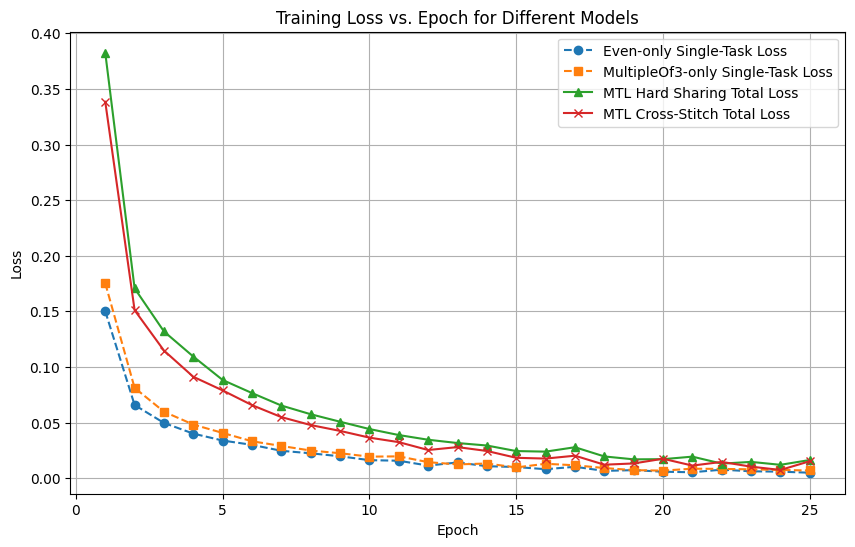

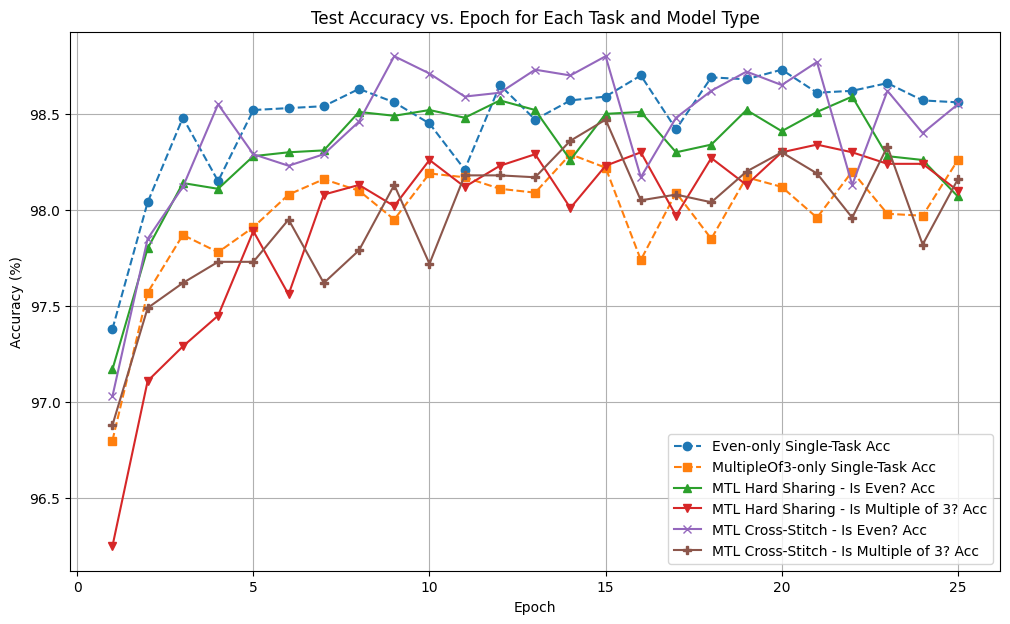

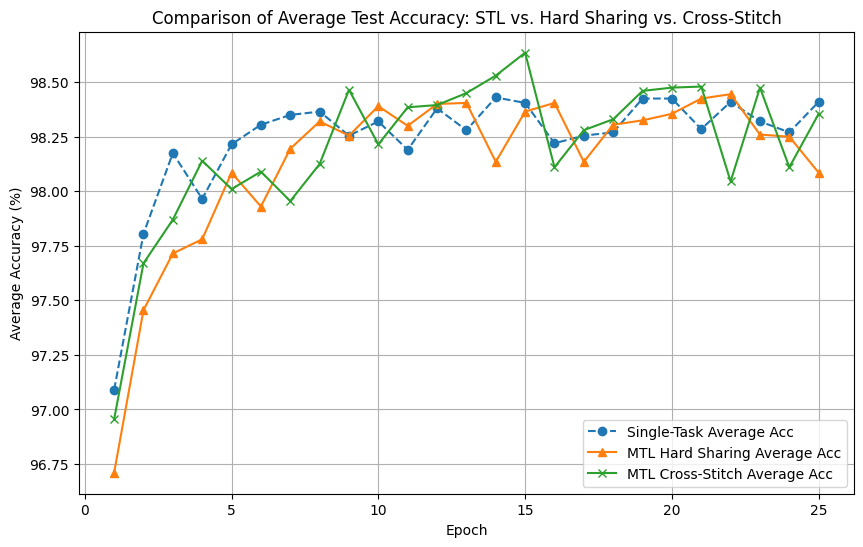

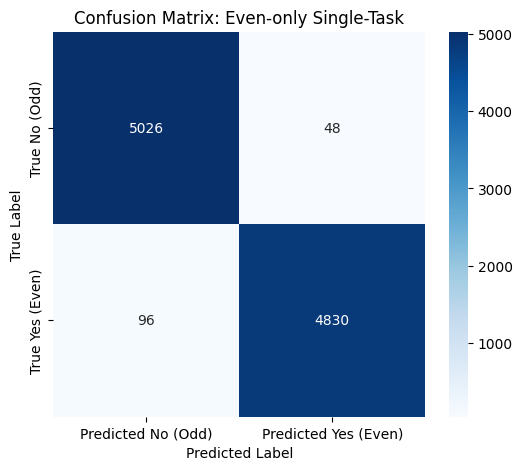

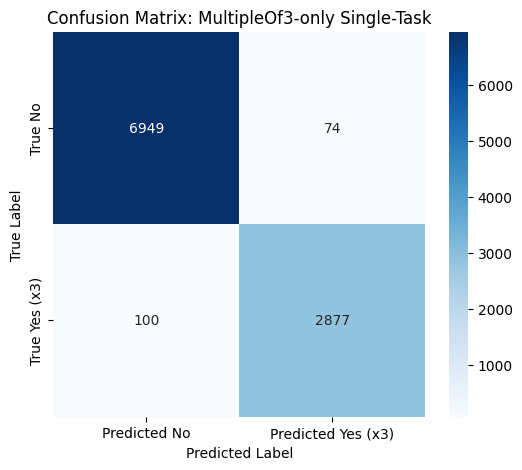

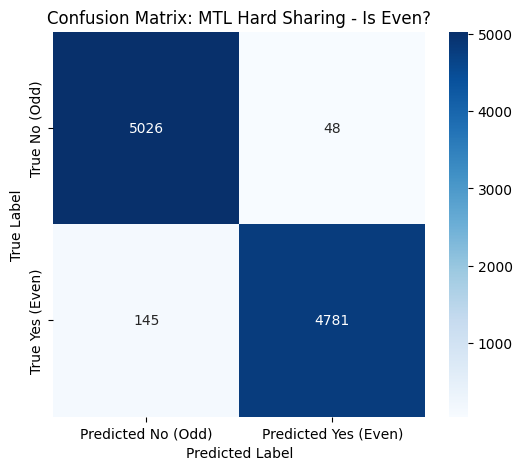

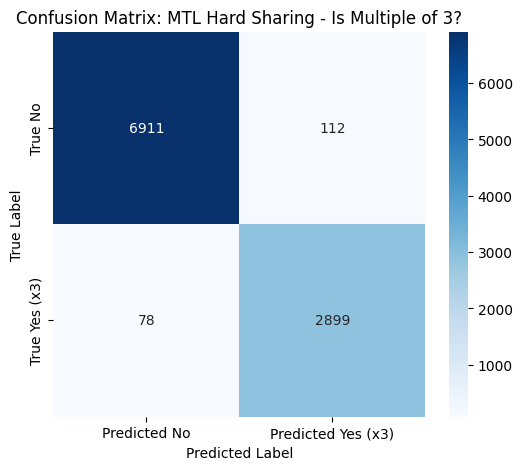

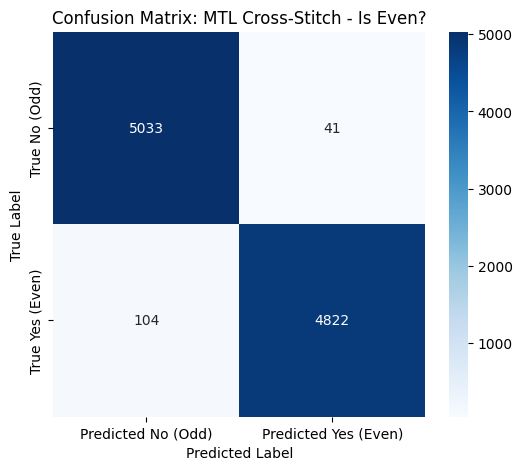

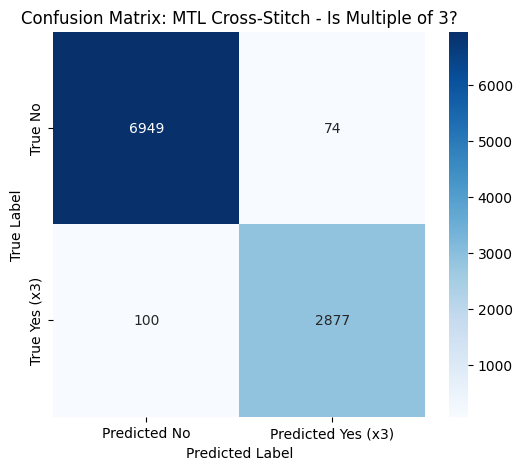


Comparison and Visualization complete.


In [13]:
# --- 7. Visualization of Results ---

print("\n--- 7. Visualization of Results ---")

epochs = range(1, num_epochs + 1) # X-axis values (epochs)

# Plot Training Loss vs. Epoch
plt.figure(figsize=(10, 6))
plt.plot(epochs, even_single_train_losses, label='Even-only Single-Task Loss', marker='o', linestyle='--')
plt.plot(epochs, mul3_single_train_losses, label='MultipleOf3-only Single-Task Loss', marker='s', linestyle='--')
plt.plot(epochs, mtl_hard_train_losses, label='MTL Hard Sharing Total Loss', marker='^')
plt.plot(epochs, mtl_cross_stitch_train_losses, label='MTL Cross-Stitch Total Loss', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs. Epoch for Different Models')
plt.legend()
plt.grid(True)
plt.show()


# Plot Test Accuracy vs. Epoch for Each Task
plt.figure(figsize=(12, 7))
plt.plot(epochs, even_single_test_accuracies, label='Even-only Single-Task Acc', marker='o', linestyle='--')
plt.plot(epochs, mul3_single_test_accuracies, label='MultipleOf3-only Single-Task Acc', marker='s', linestyle='--')
plt.plot(epochs, mtl_hard_even_test_accuracies, label='MTL Hard Sharing - Is Even? Acc', marker='^')
plt.plot(epochs, mtl_hard_mul3_test_accuracies, label='MTL Hard Sharing - Is Multiple of 3? Acc', marker='v')
plt.plot(epochs, mtl_cross_stitch_even_test_accuracies, label='MTL Cross-Stitch - Is Even? Acc', marker='x')
plt.plot(epochs, mtl_cross_stitch_mul3_test_accuracies, label='MTL Cross-Stitch - Is Multiple of 3? Acc', marker='P')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title("Test Accuracy vs. Epoch for Each Task and Model Type")
plt.legend()
plt.grid(True)
plt.show()

# Plot Average Test Accuracy vs. Epoch
# Calculate average test accuracy per epoch for Single-Task approach
single_task_avg_test_accuracies = [(even_single_test_accuracies[i] + mul3_single_test_accuracies[i]) / 2 for i in range(num_epochs)]
# Calculate average test accuracy per epoch for MTL Hard Sharing model
mtl_hard_avg_test_accuracies = [(mtl_hard_even_test_accuracies[i] + mtl_hard_mul3_test_accuracies[i]) / 2 for i in range(num_epochs)]
# Calculate average test accuracy per epoch for MTL Cross-Stitch model
mtl_cross_stitch_avg_test_accuracies = [(mtl_cross_stitch_even_test_accuracies[i] + mtl_cross_stitch_mul3_test_accuracies[i]) / 2 for i in range(num_epochs)]


plt.figure(figsize=(10, 6))
plt.plot(epochs, single_task_avg_test_accuracies, label='Single-Task Average Acc', marker='o', linestyle='--')
plt.plot(epochs, mtl_hard_avg_test_accuracies, label='MTL Hard Sharing Average Acc', marker='^')
plt.plot(epochs, mtl_cross_stitch_avg_test_accuracies, label='MTL Cross-Stitch Average Acc', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy (%)')
plt.title("Comparison of Average Test Accuracy: STL vs. Hard Sharing vs. Cross-Stitch")
plt.legend()
plt.grid(True)
plt.show()

# --- Plot Confusion Matrices (Final) ---

# Plot Confusion Matrix for Even-only Single-Task
cm_even_single = confusion_matrix(all_even_labels_even_single, all_even_preds_even_single)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_even_single, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted No (Odd)', 'Predicted Yes (Even)'], yticklabels=['True No (Odd)', 'True Yes (Even)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix: Even-only Single-Task')
plt.show()

# Plot Confusion Matrix for MultipleOf3-only Single-Task
cm_mul3_single = confusion_matrix(all_multiple_of_3_labels_mul3_single, all_multiple_of_3_preds_mul3_single)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_mul3_single, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted No', 'Predicted Yes (x3)'], yticklabels=['True No', 'True Yes (x3)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix: MultipleOf3-only Single-Task')
plt.show()

# Plot Confusion Matrix for MTL Hard Sharing - Is Even?
cm_even_mtl_hard = confusion_matrix(all_even_labels_mtl_hard, all_even_preds_mtl_hard)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_even_mtl_hard, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted No (Odd)', 'Predicted Yes (Even)'], yticklabels=['True No (Odd)', 'True Yes (Even)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix: MTL Hard Sharing - Is Even?')
plt.show()

# Plot Confusion Matrix for MTL Hard Sharing - Is Multiple of 3?
cm_mul3_mtl_hard = confusion_matrix(all_multiple_of_3_labels_mtl_hard, all_multiple_of_3_preds_mtl_hard)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_mul3_mtl_hard, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted No', 'Predicted Yes (x3)'], yticklabels=['True No', 'True Yes (x3)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix: MTL Hard Sharing - Is Multiple of 3?')
plt.show()

# Plot Confusion Matrix for MTL Cross-Stitch - Is Even?
cm_even_mtl_cross_stitch = confusion_matrix(all_even_labels_mtl_cross_stitch, all_even_preds_mtl_cross_stitch)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_even_mtl_cross_stitch, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted No (Odd)', 'Predicted Yes (Even)'], yticklabels=['True No (Odd)', 'True Yes (Even)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix: MTL Cross-Stitch - Is Even?')
plt.show()

# Plot Confusion Matrix for MTL Cross-Stitch - Is Multiple of 3?
cm_mul3_mtl_cross_stitch = confusion_matrix(all_multiple_of_3_labels_mul3_single, all_multiple_of_3_preds_mul3_single) # Bugfix: used single-task mul3 preds before
plt.figure(figsize=(6, 5))
sns.heatmap(cm_mul3_mtl_cross_stitch, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted No', 'Predicted Yes (x3)'], yticklabels=['True No', 'True Yes (x3)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix: MTL Cross-Stitch - Is Multiple of 3?')
plt.show()


print("\nComparison and Visualization complete.")

In [17]:
import pandas as pd
import json # Import the json module

# These variables are instantiated and populated from the previous cells
# (Ensure that cells 1, 2, 3, and 4 have been executed before this one)

# Parameters (calculated in previous cells, but here we use the counting function to show dynamism)
total_single_params_dynamic = count_parameters(even_single_model) + count_parameters(mul3_single_model)
mtl_hard_params_dynamic = count_parameters(mtl_hard_model)
mtl_cross_stitch_params_dynamic = count_parameters(mtl_cross_stitch_model)

# Training times (instantiated in previous cells)
total_single_train_time_dynamic = even_single_train_time + mul3_single_train_time

# Best average accuracies (instantiated in previous cells after training)
final_avg_accuracy_single = (best_even_single_test_acc + best_mul3_single_test_acc) / 2
final_avg_accuracy_mtl_hard = best_mtl_hard_avg_test_acc
final_avg_accuracy_mtl_cross_stitch = best_mtl_cross_stitch_avg_test_acc

# Create a dictionary for the summary data
summary_data = {
    "Metric": [
        "Total Parameters",
        "Training Time (s)",
        "Best Average Accuracy (%)"
    ],
    "Single-Task": [
        total_single_params_dynamic,
        round(total_single_train_time_dynamic, 2),
        round(final_avg_accuracy_single, 2)
    ],
    "Hard Sharing MTL": [
        mtl_hard_params_dynamic,
        round(mtl_hard_train_time, 2),
        round(final_avg_accuracy_mtl_hard, 2)
    ],
    "Cross-Stitch MTL": [
        mtl_cross_stitch_params_dynamic,
        round(mtl_cross_stitch_train_time, 2),
        round(final_avg_accuracy_mtl_cross_stitch, 2)
    ]
}

# Create a pandas DataFrame
summary_df = pd.DataFrame(summary_data)

# --- Save DataFrame to JSON file ---
output_json_path = "./experiment_results/summary_table.json"

try:
    # Ensure the directory exists
    import os
    os.makedirs(os.path.dirname(output_json_path), exist_ok=True)
    
    # Convert DataFrame to JSON and save
    summary_df.to_json(output_json_path, orient="records", indent=4)
    print(f"\nSummary table saved to {output_json_path}")
except Exception as e:
    print(f"\nError saving summary table to JSON: {e}")


Summary table saved to ./experiment_results/summary_table.json


| Metric                      | Single-Task | Hard Sharing MTL | Cross-Stitch MTL |
| :-------------------------- | :---------- | :--------------- | :--------------- |
| Total Parameters            | 104706.0    | 52386.0          | 104714.0         |
| Training Time (s)           | 771.1       | 393.25           | 425.95           |
| Best Average Accuracy (%)   | 98.51       | 98.44            | 98.64            |

Based on the data presented, we can draw some initial conclusions about different Multi-Task Learning (MTL) strategies. MTL techniques, such as Hard Parameter Sharing and Cross-Stitch Networks, showed promise in this introductory example. Although the Hard Sharing model dramatically reduces the number of parameters (52386.0 vs. 104706.0 for Single-Task) and training times (393.25s vs. 771.1s), the average accuracy performance remains very similar (98.44% for Hard Sharing MTL vs. 98.51% for Single-Task). Cross-Stitch Networks show a slightly higher average accuracy (98.64%) than Single-Task, while maintaining a similar number of parameters as Single-Task (104714.0) and a shorter training time (425.95s).
This example, although educational, highlights that MTL can offer computational efficiency and comparable or slightly better performance, especially when tasks are correlated. There is ample room for improvement and exploration in these techniques. Further development could include optimizing the architecture for specific problems, implementing more advanced regularization mechanisms, or combining different sharing strategies to better exploit synergies between tasks.

